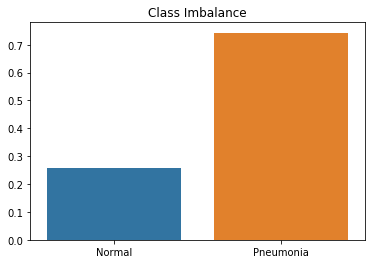

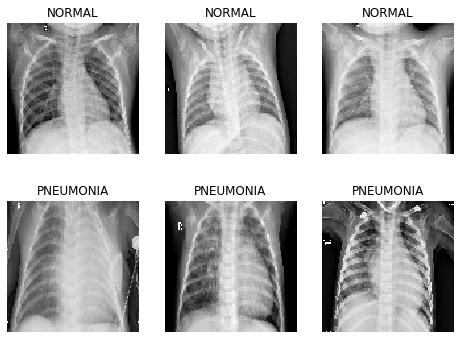

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

train_dir = './../../src/data/chest_xray/train/' # image folder

# get the list of jpegs from sub image class folders
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg')]

# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)


import seaborn as sns

normal_size = len(normal_imgs)/(len(normal_imgs)+len(pneumo_imgs))
pnue_size = len(pneumo_imgs)/(len(normal_imgs)+len(pneumo_imgs))


ax = sns.barplot(x = ['Normal', 'Pneumonia'],
                 y = [normal_size, pnue_size]);
ax.set_title("Class Imbalance");


# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_dir}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

The first thing to note is that we have a class imbalance between healthy and pnuemonia patients where there are fewer healthy picture than ones with pnuemonia. In medidical imaging this is a common occurance. The people who are sicker are more likely to recieve chest x rays and therefore we would expect there to be a higher number of x rays featuring patients with pnueomonia.

The image above shows three healthy chest xrays and three chest xrays of patients with pneumonia. Patients with pnuemonia have less defined organ structures. There is generally a "haze" around the lung area. This haze is caused by a build up of fluid and scarring caused by bacterial or viral infections causing the pnuemonia.

However, this is just a small sample, in fact, the central pneuomonia image is take from the side whereas the other 5 images are taken from the anterior to posterior axis.

To see if there are differences in the in the xrays of sick versus healthy patients overall, calculated the mean value for each pixel in the image array and took the mean of those pixels.

To do this, we imported each picture seperately, adjusted their size so that they are all 224,224 and converted them to grayscale. We then flattened the two dimensional array to 1 dimension using np.ravel() and concatenated all of the vectors into one matrix call full_mat (full_matrix).

Once we had our full matrix, we took the mean accross each row (matching pixels in the image) concatenated them into an n X m matrix

In [2]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np(f'{train_dir}/NORMAL/', normal_imgs)
pnemonia_images = img2np(f'{train_dir}/PNEUMONIA/', pneumo_imgs)

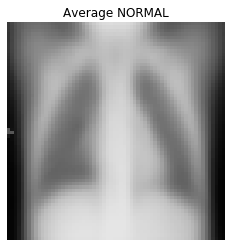

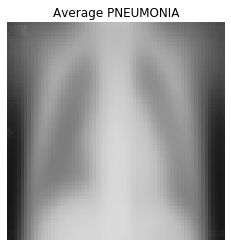

In [72]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0) 
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'PNEUMONIA')

Our intuition from seeing 3 random images held true in the aggregate. The Average Pneumonia patients chest cavity is blurred by the fluid and scarification from the their infection. 

Visual analysis builds intuition that there is a difference between average difference between each pixel. We wanted to visulize the difference the means of the images to demonstrate the regions where the differences in pixel value was greater.

s.find returns -1 if the string does not contain the string in question

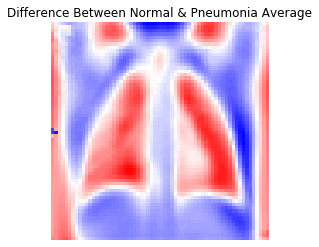

In [73]:
contrast_mean = pneu_mean - norm_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()

Pixels that are blue are closer to 0 and pixels that are red are closer 255. We calculated the difference by subtracting the healthy individual's average pixel value away from the the pneuomonia patients pixel value. Therefore, the more red a region is, the brighter the region was in sick patients than in healthy ones. The result was that the chest cavity, specifically the lungs of the patients were far brighter in the pneumonia patients than in healthy individuals. 

In addition to the mean difference between pixels, we also were interested in the variance between pixels for each group. To do this, we repeated the above steps, defining a new function that takes as it's arguement full matrix and returns the variance of each pixel in the matrix.

In order to increase the brightness, I raised the pixel standard deviation to 1.1 so that the bright areas were amplified. 

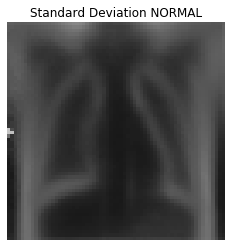

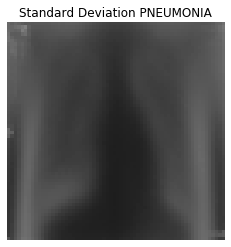

In [75]:
def find_var_img(full_mat, title, size = (64, 64)):
    # calculate the average
    std_img = (np.std(full_mat, axis = 0))**1.1
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_var_img(normal_images, 'NORMAL')
pneu_std = find_var_img(pnemonia_images, 'PNEUMONIA')

The patients with pnuemonia had greater variation accross their entire lung area whereas healthy patients tended to have variation in the size of their lungs, given by the outline in the of the lung having a higher standard deviation. 

Similar to mean pixel intensity, let's look at the differences between the two classes in the standard deviation of the pixels

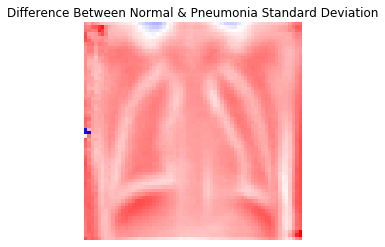

In [76]:
contrast_std = pneu_std -norm_std
plt.imshow(contrast_std, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Standard Deviation')
plt.axis('off')
plt.show()

Here, we can see that the overall shape of the lungs changed very little between the two classes. However, the pixel intensity within and around the lungs was much higher in the Pnuemonia class. This once again was to be expected. Pnuemonia doesn't effect all regions of the lungs uniformly. It can be more intense in specific regions however the lungs over all are similar in size whether or not you have an infection. 

A caveat to the above statement is that patients with pnuemonia's lungs appeared "longer" than those without. This is highlighted by the shadowy regions on either lower regions of the lung.  The reason for this is likely the accumulation of fluid at the base of the lungs being detected by the x ray.

Next, we wanted to use eigendecomposition/principal component analysis to find which features of the image stand out and potentially reduce the dimensions of our data set for future modelling. This process is also called eigenfaces, and was first usedin 1987 by Turk and Pentland for face classification. However it can be broadly used to extract the most important features from images in each class. 

To acheive this, we will use the sklaern PCA implementation but we will only look at eigenimages that explain 60% of the total varation in the dataset.

Number of PNEUMONIA PC:  7


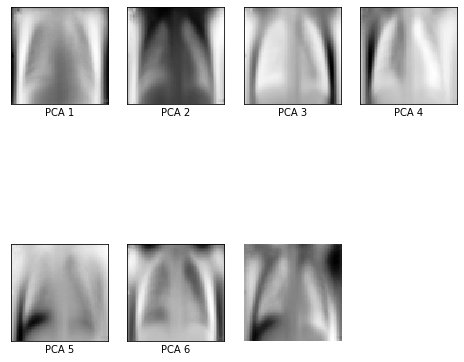

Number of NORMAL PC:  14


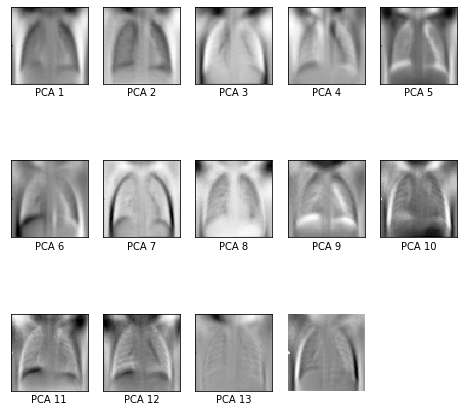

In [68]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.6, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print(f'Number of {title} PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.set_xlabel(f"PCA {i+1}")
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

    
plot_pca(eigenimages(pnemonia_images, 'PNEUMONIA'))
plot_pca(eigenimages(normal_images, 'NORMAL')) 

Interestingly, in order to explain 60% of the variation in the data sets, you needed twice the number of PCA's from the healthy class than the sick class. A theorized reason for this is that since the healthy class had less variance over all, the difference between features was less impactful. 


Interestingly, PCA 1 of pnuemonia revealed that over all brightness of the image was indicative of the class. The next PCA highlights the size of the lungs themselves. Healthy PCA1, PCA2 and PCA3 on the otherhand are all highlighting well defined edges around the lungs. Likely, this is due to our previous finding that the variation around in the size of the lung larger than the variation within the lungs for healthy patients.


We hope that our cnn will be able to pull out those contours in the convolutions and 

# Our takeaways from EDA:
- Class Imbalance:
    - There are 3x the number of x rays of infected lungs than healthy we will address this via:
        - Data Augmentation, though we are hesitant about using augmentation on medical images
        - Class weighting. We will calculate the inverse class frequency and use those as the weights in our model
- Feature Selection:
    - We hope to train our CNN to pick out 3 key features:
        - Cloudiness of the image/overall brightness
        - The dark well defined chest cavity of healthy people
        - The region at the base of the lungs corresponding to build up of fluids
